# Import Required Libraries
Import the necessary libraries, including torch, torchvision, and matplotlib.

In [1]:
# Import Required Libraries
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Download MNIST-C Dataset
Download the MNIST-C dataset from the official source or a specified URL.

In [1]:
# Download MNIST-C Dataset
import os
import urllib.request
import zipfile

# Define the URL for the MNIST-C dataset
url = 'https://zenodo.org/records/3239543/files/mnist_c.zip?download=1'

# Define the directory to save the dataset
dataset_dir = '/cis/home/xhan56/code/wtr/data'

# Create the directory if it doesn't exist
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# Define the path to save the zip file
zip_path = os.path.join(dataset_dir, 'mnist_c.zip')

# Download the dataset
urllib.request.urlretrieve(url, zip_path)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)

# Remove the tar file after extraction
os.remove(zip_path)

# Print a message indicating completion
print("MNIST-C dataset downloaded and extracted successfully.")

MNIST-C dataset downloaded and extracted successfully.


# Load Dataset
Use torchvision to load the MNIST-C dataset into a DataLoader.

In [28]:
from torch.utils.data import Dataset
import numpy as np

class NpyDataset(Dataset):
    """
    A custom Dataset that loads .npy image data and corresponding labels.
    """
    def __init__(self, images_path, labels_path, transform=None):
        """
        Args:
            images_path (str): Path to the .npy file containing image data.
            labels_path (str): Path to the .npy file containing labels.
            transform (callable, optional): Optional transform to be applied
                on each image.
        """
        # Load .npy arrays
        self.images = np.load(images_path)     # shape typically (N, H, W) or (N, H, W, C)
        self.labels = np.load(labels_path)     # shape (N,)

        # (Optional) Convert data to float32 if needed, or keep as is
        # self.images = self.images.astype(np.float32)

        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        # If images are grayscale, you might need to add a channel dimension.
        # For example, if `img.shape` is (28, 28), do this:
        # img = np.expand_dims(img, axis=0)  # Now it's (1, 28, 28)

        # Convert numpy array to torch Tensor
        # img = torch.from_numpy(img)

        if self.transform:
            # If the transform expects a PIL image, you may need 
            # to convert the numpy/torch image to PIL. Alternatively, 
            # you can use transforms that work directly on tensors.
            img = self.transform(img)
        print('img.shape', img.shape)
        return img, label

In [20]:
# Load Dataset
from torch.utils.data import random_split, DataLoader
import os

def load_mnist_c(corruption_type='fog'):
    # Define the path to the MNIST-C dataset
    mnist_c_path = os.path.join('/cis/home/xhan56/code/wtr/data/mnist_c', corruption_type)

    # Define a transform to convert the images to tensors
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Load the dataset using ImageFolder
    mnist_c_train = NpyDataset(os.path.join(mnist_c_path, 'train_images.npy'), 
                            os.path.join(mnist_c_path, 'train_labels.npy'), transform=transform)
    mnist_c_test = NpyDataset(os.path.join(mnist_c_path, 'test_images.npy'), 
                            os.path.join(mnist_c_path, 'test_labels.npy'), transform=transform)
    print('test dataset shape:', mnist_c_test.images.shape)
    # Create a DataLoader for the dataset
    train_loader_c = DataLoader(mnist_c_train, batch_size=64, shuffle=True)
    test_loader_c = DataLoader(mnist_c_test, batch_size=64, shuffle=True)

    return train_loader_c, test_loader_c

In [30]:
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import os

class MixtureMNISTDataset(Dataset):
    """
    A dataset that returns a mixture of clean MNIST and corrupted MNIST samples.
    Each time you request an item, it randomly decides whether to return
    from the corrupted set or from the clean set.

    Args:
        clean_dataset (Dataset): A PyTorch dataset for standard MNIST.
        corrupted_dataset (Dataset): A PyTorch dataset for MNIST-C (or any corrupted version).
        mixture_ratio (float): Probability of drawing a corrupted sample (0.0 to 1.0).
        total_size (int, optional): How many total samples to emulate in this mixture.
            If None, defaults to the maximum size of the two input datasets.
        transform (callable, optional): An optional transform to apply on the image.
    """
    def __init__(self, 
                 clean_dataset, 
                 corrupted_dataset, 
                 mixture_ratio=0.5, 
                 total_size=None,
                 transform=None):
        super().__init__()
        self.clean_dataset = clean_dataset
        self.corrupted_dataset = corrupted_dataset
        self.mixture_ratio = mixture_ratio
        self.transform = transform
        
        # Define how large the "mixture dataset" is, in total.
        # By default, we pick the max length so that you can iterate for many samples.
        if total_size is None:
            self.total_size = max(len(self.clean_dataset), len(self.corrupted_dataset))
        else:
            self.total_size = total_size

    def __len__(self):
        return self.total_size

    def __getitem__(self, idx):
        """
        Randomly choose either a corrupted sample or a clean sample
        according to the mixture_ratio.
        """
        # Decide: do we pick corrupted or clean?
        if np.random.rand() < self.mixture_ratio:
            # Pick from corrupted dataset
            img, label = self.corrupted_dataset[idx]
        else:
            # Pick from the clean dataset
            img, label = self.clean_dataset[idx]

        # Ensure the image is a numpy array before applying the transform
        if isinstance(img, torch.Tensor):
            img = img.numpy()

        if self.transform is not None:
            img = self.transform(img)

        return img, label

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Common MNIST mean/std
])
corruption_type = 'fog'
mnist_c_path = os.path.join('/cis/home/xhan56/code/wtr/data/mnist_c', corruption_type)

full_train_dataset = torchvision.datasets.MNIST(
    root='/cis/home/xhan56/code/wtr/data',       # Directory to store the MNIST data
    train=True,
    transform=None  # No transform here
)
train_dataset, val_dataset = random_split(full_train_dataset, [50000, 10000])
corrupted_dataset = NpyDataset(os.path.join(mnist_c_path, 'test_images.npy'), 
                            os.path.join(mnist_c_path, 'test_labels.npy'))

mixture_dataset = MixtureMNISTDataset(
    clean_dataset=val_dataset,
    corrupted_dataset=corrupted_dataset,
    mixture_ratio=0.9,
    transform=transform
)
loader = DataLoader(
    dataset=corrupted_dataset,
    batch_size=64,
    shuffle=True,
    drop_last=False
)

# dataiter = iter(loader)
# images, labels = next(dataiter)
for images, labels in loader:
    print('images.shape:', images.shape)
    print('labels.shape:', labels.shape)

img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape (28, 28, 1)
img.shape 

# Visualize Sample Images
Use matplotlib to visualize a few sample images from the dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.5..1.4404955].


test dataset shape: (10000, 28, 28, 1)


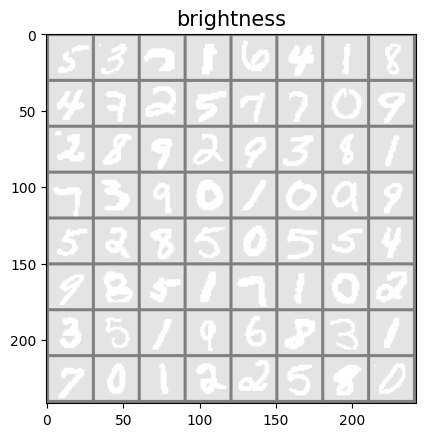

In [22]:
# Visualize Sample Images
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow_c(img, corruption_type):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.title(f'{corruption_type}', fontsize=15)
    plt.show()

corruption_type = 'brightness'
train_loader, _ = load_mnist_c(corruption_type=corruption_type)
# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow_c(torchvision.utils.make_grid(images) / 1.5, corruption_type)

In [17]:
def load_mnist(batch_size=64, normalize=True):
    """
    Load the MNIST dataset with optional normalization.

    Args:
        batch_size (int): Number of samples per batch in the DataLoader.
        normalize (bool): Whether to apply standard MNIST normalization.

    Returns:
        train_loader (DataLoader): DataLoader for the training set.
        test_loader (DataLoader): DataLoader for the test set.
    """

    # Transformations: convert to tensor and optionally normalize
    if normalize:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))  # Common MNIST mean/std
        ])
    else:
        transform = transforms.Compose([
            transforms.ToTensor()
        ])

    # Load train & test sets
    full_train_dataset = torchvision.datasets.MNIST(
        root='/cis/home/xhan56/code/wtr/data',       # Directory to store the MNIST data
        train=True,
        transform=transform
    )
    test_dataset = torchvision.datasets.MNIST(
        root='/cis/home/xhan56/code/wtr/data',
        train=False,
        transform=transform
    )
    train_dataset, val_dataset = random_split(full_train_dataset, [50000, 10000])
    print('test dataset shape:', test_dataset.data.shape)
    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=True
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    return train_loader, val_loader, test_loader

In [18]:
train_loader, val_loader, test_loader = load_mnist(batch_size=64, normalize=True)

# Iterate through one batch to see shapes:
images, labels = next(iter(train_loader))
print("Batch of images shape:", images.shape)  # (64, 1, 28, 28)
print("Batch of labels shape:", labels.shape)  # (64,)

test dataset shape: torch.Size([10000, 28, 28])
Batch of images shape: torch.Size([64, 1, 28, 28])
Batch of labels shape: torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.28789353..1.9107434].


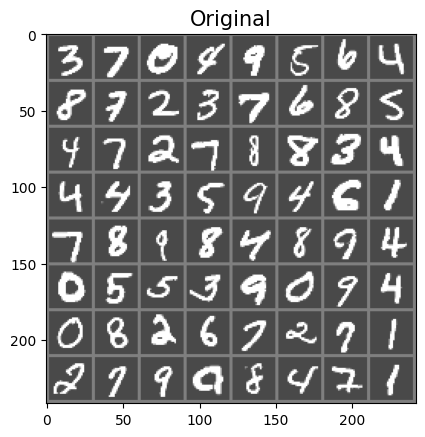

In [20]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.title('Original', fontsize=15)
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

In [21]:
import torch.nn as nn

class MLP(nn.Module):
    """
    A simple 3-layer MLP for MNIST classification.
    Input: (N, 1, 28, 28)
    Output: (N, 10) for 10 classes (digits 0..9)
    """
    def __init__(self, input_size=784, hidden_size=256, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x shape: (N, 1, 28, 28)
        # Flatten to (N, 784)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

In [22]:
def train_one_epoch(model, device, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # Compute accuracy
        _, predicted = outputs.max(dim=1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, device, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            _, predicted = outputs.max(dim=1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [28]:
import torch.optim as optim

lr = 1e-3
epochs = 10
batch_size = 64
train_clean = True
corruption_type = 'fog'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_size=784, hidden_size=256, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_loader, test_loader = load_mnist(batch_size)
train_loader_c, test_loader_c = load_mnist_c(corruption_type=corruption_type)

if train_clean:
    print("Training on clean MNIST dataset.")
else:
    print(f"Training on {corruption_type} MNIST dataset.")

best_clean_acc = 0.0

for epoch in range(epochs):
    # Train on whichever dataset is chosen
    if train_clean:
        train_loss, train_acc = train_one_epoch(model, device, train_loader, optimizer, criterion)
    else:
        train_loss, train_acc = train_one_epoch(model, device, train_loader_c, optimizer, criterion)

    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%")

    # Evaluate on both clean and corrupted to see performance
    clean_loss, clean_acc = evaluate(model, device, test_loader, criterion)
    print(f"   Clean Test Loss: {clean_loss:.4f}, Clean Acc: {clean_acc*100:.2f}%")

    corrupt_loss, corrupt_acc = evaluate(model, device, test_loader_c, criterion)
    print(f"   Corrupted Test Loss: {corrupt_loss:.4f}, Corrupted Acc: {corrupt_acc*100:.2f}%")

    # Save checkpoint if clean accuracy improves
    if clean_acc > best_clean_acc:
        best_clean_acc = clean_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("Checkpoint saved for best model with clean accuracy: {:.2f}%".format(best_clean_acc * 100))

Training on clean MNIST dataset.
Epoch [1/10] - Train Loss: 0.2194, Train Acc: 93.37%
   Clean Test Loss: 0.1017, Clean Acc: 96.80%
   Corrupted Test Loss: 2.1847, Corrupted Acc: 33.52%
Checkpoint saved for best model with clean accuracy: 96.80%
Epoch [2/10] - Train Loss: 0.0923, Train Acc: 97.10%
   Clean Test Loss: 0.1012, Clean Acc: 96.72%
   Corrupted Test Loss: 2.3044, Corrupted Acc: 37.24%
Epoch [3/10] - Train Loss: 0.0638, Train Acc: 98.01%
   Clean Test Loss: 0.0865, Clean Acc: 97.34%
   Corrupted Test Loss: 5.7396, Corrupted Acc: 22.81%
Checkpoint saved for best model with clean accuracy: 97.34%
Epoch [4/10] - Train Loss: 0.0508, Train Acc: 98.33%
   Clean Test Loss: 0.0783, Clean Acc: 97.63%
   Corrupted Test Loss: 3.9364, Corrupted Acc: 27.95%
Checkpoint saved for best model with clean accuracy: 97.63%
Epoch [5/10] - Train Loss: 0.0424, Train Acc: 98.64%
   Clean Test Loss: 0.0731, Clean Acc: 97.82%
   Corrupted Test Loss: 5.4367, Corrupted Acc: 23.23%
Checkpoint saved for b

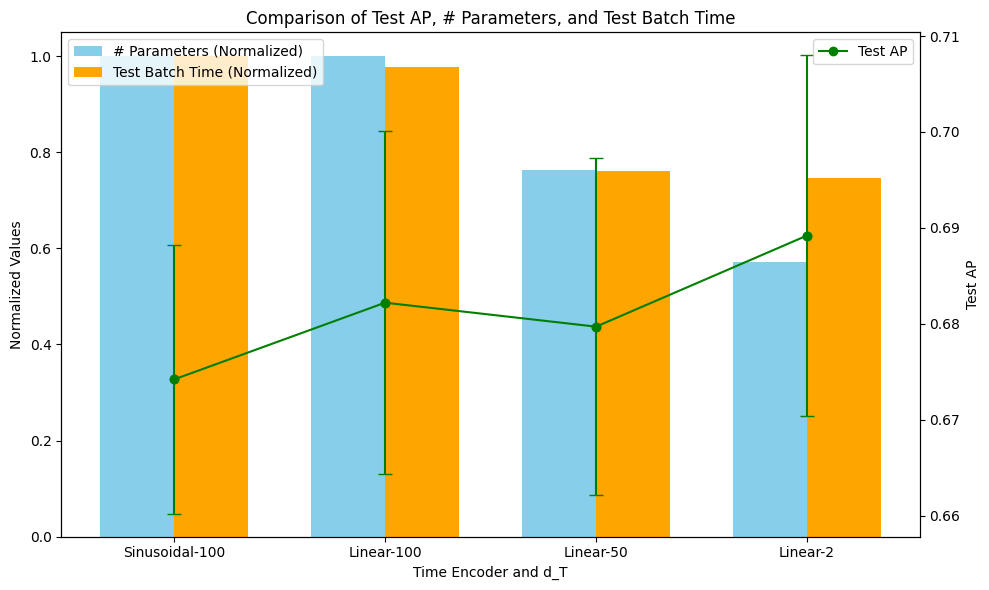

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Data
labels = ["Sinusoidal-100", "Linear-100", "Linear-50", "Linear-2"]
test_ap = [0.6742, 0.6822, 0.6797, 0.6892]
test_ap_err = [0.0140, 0.0179, 0.0176, 0.0188]
num_parameters = [1052945, 1052945, 803345, 601361]
test_batch_time = [0.16444, 0.16088, 0.12506, 0.12277]

# Normalize Parameters and Batch Time for visualization clarity
norm_params = [x / max(num_parameters) for x in num_parameters]
norm_time = [x / max(test_batch_time) for x in test_batch_time]

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for # Parameters and Test Batch Time
bar_width = 0.35
x = np.arange(len(labels))
ax1.bar(x - bar_width / 2, norm_params, bar_width, label="# Parameters (Normalized)", color='skyblue')
ax1.bar(x + bar_width / 2, norm_time, bar_width, label="Test Batch Time (Normalized)", color='orange')
ax1.set_ylabel("Normalized Values")
ax1.set_xlabel("Time Encoder and d_T")
ax1.set_title("Comparison of Test AP, # Parameters, and Test Batch Time")
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend(loc="upper left")

# Line chart for Test AP
ax2 = ax1.twinx()
ax2.plot(x, test_ap, color='green', marker='o', label="Test AP")
ax2.errorbar(x, test_ap, yerr=test_ap_err, fmt='o', color='green', capsize=5)
ax2.set_ylabel("Test AP")
ax2.legend(loc="upper right")

# Show plot
plt.tight_layout()
plt.show()

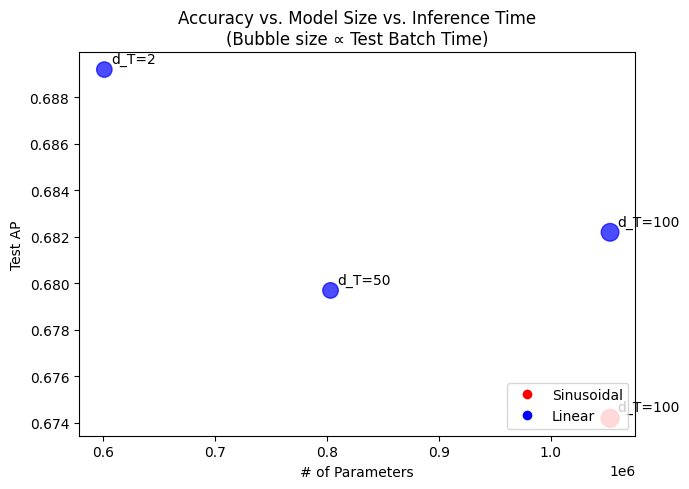

In [3]:
data = [
    {
        "label": "Sinusoidal d_T=100",
        "encoder": "Sinusoidal",
        "d_T": 100,
        "test_ap": 0.6742,
        "params": 1052945,
        "time": 0.16444
    },
    {
        "label": "Linear d_T=100",
        "encoder": "Linear",
        "d_T": 100,
        "test_ap": 0.6822,
        "params": 1052945,
        "time": 0.16088
    },
    {
        "label": "Linear d_T=50",
        "encoder": "Linear",
        "d_T": 50,
        "test_ap": 0.6797,
        "params": 803345,
        "time": 0.12506
    },
    {
        "label": "Linear d_T=2",
        "encoder": "Linear",
        "d_T": 2,
        "test_ap": 0.6892,
        "params": 601361,
        "time": 0.12277
    },
]

# Separate data for plotting
x = [d["params"] for d in data]      # number of parameters
y = [d["test_ap"] for d in data]     # test AP
sizes = [d["time"] * 1000 for d in data]  # scale bubble sizes for visibility
colors = ["red" if d["encoder"] == "Sinusoidal" else "blue" for d in data]

fig, ax = plt.subplots(figsize=(7,5))

# Draw scatter points
scatter = ax.scatter(x, y, s=sizes, c=colors, alpha=0.7)

# Label each point with d_T
for d in data:
    ax.annotate(f"d_T={d['d_T']}", 
                (d["params"], d["test_ap"]), 
                textcoords="offset points", 
                xytext=(5,5))

ax.set_xlabel("# of Parameters")
ax.set_ylabel("Test AP")
ax.set_title("Accuracy vs. Model Size vs. Inference Time\n(Bubble size ∝ Test Batch Time)")

# Create a legend for the encoders (Sinusoidal vs. Linear)
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Sinusoidal',
           markerfacecolor='red', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Linear',
           markerfacecolor='blue', markersize=8)
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

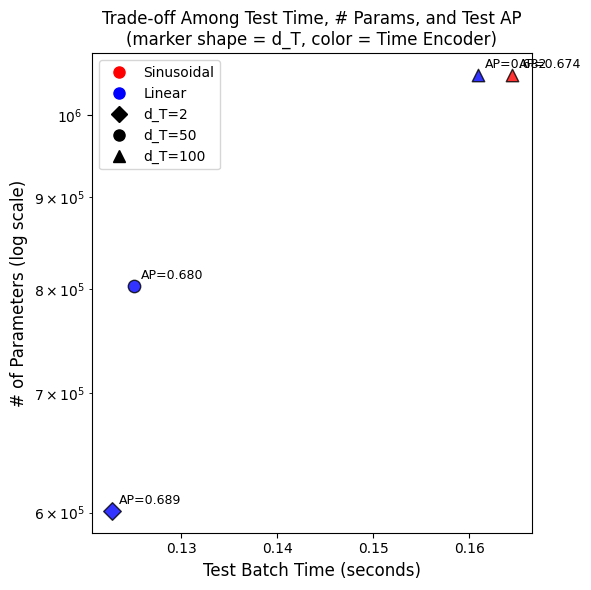

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your actual values)
data = [
    {
        "time_encoder": "Sinusoidal", 
        "d_T": 100,
        "test_ap": 0.6742,
        "test_time": 0.16444,
        "num_params": 1052945
    },
    {
        "time_encoder": "Linear",
        "d_T": 100,
        "test_ap": 0.6822,
        "test_time": 0.16088,
        "num_params": 1052945
    },
    {
        "time_encoder": "Linear",
        "d_T": 50,
        "test_ap": 0.6797,
        "test_time": 0.12506,
        "num_params": 803345
    },
    {
        "time_encoder": "Linear",
        "d_T": 2,
        "test_ap": 0.6892,
        "test_time": 0.12277,
        "num_params": 601361
    }
]

# 1) Map each Time Encoder to a color
color_map = {
    "Sinusoidal": "red",
    "Linear": "blue"
}

# 2) Map each d_T to a distinct marker
marker_map = {
    2: "D",     # diamond
    50: "o",    # circle
    100: "^",   # triangle
}

fig, ax = plt.subplots(figsize=(6,6))

for entry in data:
    x = entry["test_time"]
    y = entry["num_params"]
    enc = entry["time_encoder"]
    dt = entry["d_T"]
    
    # Choose marker/color from the maps
    marker_style = marker_map.get(dt, "s")  # default square if not in map
    color_style = color_map.get(enc, "black")

    # Scatter plot
    ax.scatter(
        x, y,
        marker=marker_style,
        color=color_style,
        s=80,          # marker size
        alpha=0.8,
        edgecolors='k' # black edges can help visibility
    )
    
    # Annotate each point with Test AP
    ax.annotate(
        f"AP={entry['test_ap']:.3f}",
        (x, y),
        textcoords="offset points",
        xytext=(5, 5),
        fontsize=9
    )

# Optional: use log-scale on parameters axis (y‐axis)
ax.set_yscale("log")

# Label axes
ax.set_xlabel("Test Batch Time (seconds)", fontsize=12)
ax.set_ylabel("# of Parameters (log scale)", fontsize=12)
ax.set_title("Trade-off Among Test Time, # Params, and Test AP\n(marker shape = d_T, color = Time Encoder)", fontsize=12)

# Create a custom legend for Time Encoder
import matplotlib.lines as mlines

sin_line = mlines.Line2D([], [], color='red', marker='o', linestyle='None',
                         markersize=8, label='Sinusoidal')
lin_line = mlines.Line2D([], [], color='blue', marker='o', linestyle='None',
                         markersize=8, label='Linear')

# Create a custom legend for d_T as well (using a separate set of markers)
dT_lines = []
for d_val, m in marker_map.items():
    dT_lines.append(mlines.Line2D([], [], color='black', marker=m, linestyle='None', 
                                  markersize=8, label=f"d_T={d_val}"))

# We can combine them into a single legend or do two legends
# E.g., combine everything in a single list:
legend_handles = [sin_line, lin_line] + dT_lines
ax.legend(handles=legend_handles, loc='best')

plt.tight_layout()
plt.show()

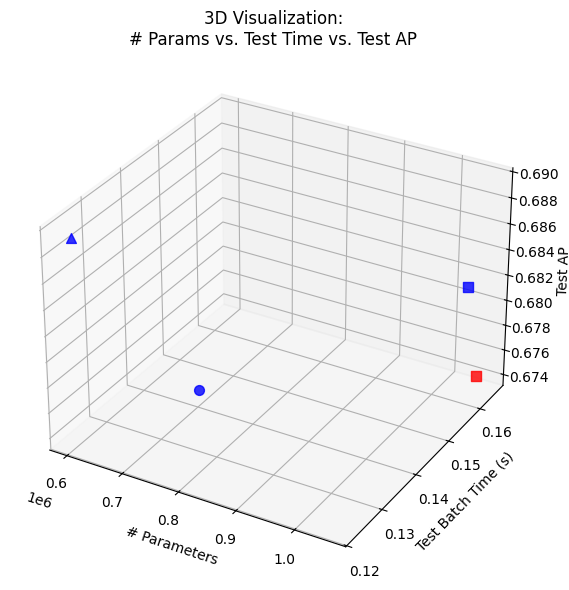

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection

# Example data: each entry is a dictionary
data = [
    {
        "time_encoder": "Sinusoidal",
        "d_T": 100,
        "test_ap": 0.6742,
        "num_params": 1052945,
        "test_time": 0.16444
    },
    {
        "time_encoder": "Linear",
        "d_T": 100,
        "test_ap": 0.6822,
        "num_params": 1052945,
        "test_time": 0.16088
    },
    {
        "time_encoder": "Linear",
        "d_T": 50,
        "test_ap": 0.6797,
        "num_params": 803345,
        "test_time": 0.12506
    },
    {
        "time_encoder": "Linear",
        "d_T": 2,
        "test_ap": 0.6892,
        "num_params": 601361,
        "test_time": 0.12277
    },
]

# Map each time encoder to a color
color_map = {
    "Sinusoidal": "red",
    "Linear": "blue"
}

# Map each d_T to a marker shape
marker_map = {
    2: "^",    # triangle
    50: "o",   # circle
    100: "s",  # square
}

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

for entry in data:
    x_val = entry["num_params"]
    y_val = entry["test_time"]
    z_val = entry["test_ap"]
    
    color_style = color_map.get(entry["time_encoder"], "gray")
    marker_style = marker_map.get(entry["d_T"], "d")
    
    ax.scatter(
        x_val, y_val, z_val,
        color=color_style,
        marker=marker_style,
        s=50,
        alpha=0.8
    )
    
    # Optional: annotate each point with d_T or AP
    # ax.text(x_val, y_val, z_val, f"d_T={entry['d_T']}", size=8)

# Label axes
ax.set_xlabel('# Parameters')
ax.set_ylabel('Test Batch Time (s)')
ax.set_zlabel('Test AP')

ax.set_title('3D Visualization:\n# Params vs. Test Time vs. Test AP')

plt.tight_layout()
plt.show()

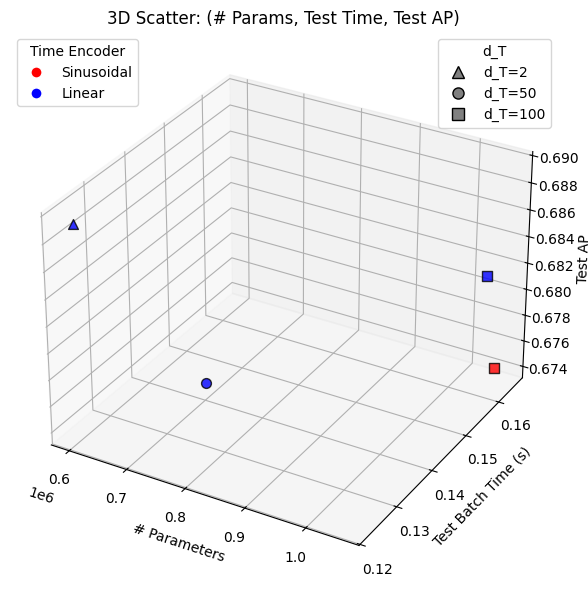

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

# Example data: each entry is a dictionary
data = [
    {
        "time_encoder": "Sinusoidal",
        "d_T": 100,
        "test_ap": 0.6742,
        "num_params": 1052945,
        "test_time": 0.16444
    },
    {
        "time_encoder": "Linear",
        "d_T": 100,
        "test_ap": 0.6822,
        "num_params": 1052945,
        "test_time": 0.16088
    },
    {
        "time_encoder": "Linear",
        "d_T": 50,
        "test_ap": 0.6797,
        "num_params": 803345,
        "test_time": 0.12506
    },
    {
        "time_encoder": "Linear",
        "d_T": 2,
        "test_ap": 0.6892,
        "num_params": 601361,
        "test_time": 0.12277
    },
]

# Map each Time Encoder to a color
color_map = {
    "Sinusoidal": "red",
    "Linear": "blue"
}

# Map each d_T to a marker shape
marker_map = {
    2: "^",    # triangle
    50: "o",   # circle
    100: "s",  # square
}

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

for entry in data:
    x_val = entry["num_params"]
    y_val = entry["test_time"]
    z_val = entry["test_ap"]
    
    c = color_map[entry["time_encoder"]]
    m = marker_map[entry["d_T"]]

    ax.scatter(
        x_val, y_val, z_val,
        color=c,
        marker=m,
        s=50,
        alpha=0.8,
        edgecolors='k'
    )
    
    # Optional annotation: label each point with (AP, d_T), etc.
    # ax.text(x_val, y_val, z_val, f"d_T={entry['d_T']}\nAP={entry['test_ap']:.3f}", size=7)

# Label the axes
ax.set_xlabel('# Parameters')
ax.set_ylabel('Test Batch Time (s)')
ax.set_zlabel('Test AP')
ax.set_title('3D Scatter: (# Params, Test Time, Test AP)')

############################################################
# Create a legend for the time encoders (Sinusoidal vs. Linear).
# We use dummy handles with the same color as actual points.
encoder_legend_handles = [
    Line2D([0], [0], marker='o', color='w', label='Sinusoidal',
           markerfacecolor='red', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Linear',
           markerfacecolor='blue', markersize=8)
]
encoder_legend = ax.legend(handles=encoder_legend_handles, 
                           title="Time Encoder",
                           loc='upper left')

# Create another legend for the d_T marker shapes
dT_legend_handles = []
for d_val, marker_symbol in marker_map.items():
    dT_legend_handles.append(
        Line2D([0], [0], marker=marker_symbol, color='w', label=f'd_T={d_val}',
               markerfacecolor='gray', markeredgecolor='k', markersize=8)
    )
dT_legend = ax.legend(handles=dT_legend_handles, 
                      title="d_T", 
                      loc='upper right')

# Add the first legend back onto the axis
ax.add_artist(encoder_legend)

plt.tight_layout()
plt.show()